# **Notebook for implementation of model built on top of VGG-16 architecture to detect glaucoma**

For this project, we have chosen Tensorflow as the backend.TensorFlow is a free and open-source software library for machine learning. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.Below code cell imports the Tensorflow library. 

Keras is an open-source software library that provides a Python interface for artificial neural networks. Keras acts as an interface for the TensorFlow library. Below we have imported some functions of Keras which are needed to make our model.Each function will be explained in detail with it's implementation below.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [1]:
from keras.models import load_model
from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import preprocess_input


ImageDataGenerator is a powerful tool to fight overfitting in deep learning models.Overfitting is said to occur when your model becomes too specific and does not generalize well. So any dataset used has to be as diverse as possible which can be done using augmentation which is basically performing operations like flipping,rotating,zooming and translating images.ImageDataGenerator performs some of the above transformations on dataset during each epoch.This is only performed on training dataset with preprocessing for VGG-16 model applied.For test dataset, only preprocessing is applied which includes operations on RGB values,normalization and standardization

In [ ]:
aug_img = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,fill_mode='nearest')

In [ ]:
std_img=ImageDataGenerator(preprocessing_function=preprocess_input)

Since Google Colab can't directly access files on system, dataset is uploaded on Google Drive which must be connected to Colab to enable access.For this we mount the drive on Colab

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


VGG-16 model expects input of dimensions 224 x 224.Hence, we give a target size of that to both train_imgs and test_imgs generated from generators we have created with a batch size of 32 for training.Setting shuffle to false makes sure order doesm't get rearranged after every epoch.

In [ ]:
train_imgs=aug_img.flow_from_directory('/content/drive/MyDrive/FINAL_DATASET/TRAIN',target_size=(224,224),batch_size=32,shuffle=False)
test_imgs=std_img.flow_from_directory('/content/drive/MyDrive/FINAL_DATASET/TEST',target_size=(224,224),batch_size=32,shuffle=False)

Found 1335 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


ImageDataGenerator assigns labels based on folders present in directory given as input.This can be seen below

In [ ]:
test_imgs.class_indices

{'NORMAL': 0, 'POSITIVE': 1}

We import VGG16 model,remove the classifier and assign pre-trained weights to it.First, we must freeze the layers i.e make sure weights of base model don't get updated during training so that we can optimize custom classifier built on top

In [ ]:
base_model=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.trainable=False

58892288/58889256 [==============================] - 1s 0us/step


Now with summary function we will view details of base model

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In above,Convolution layer is used to detect edges,shapes and patterns.MaxPooling is used to halve dimensions of image.Below, we have built our custom classifier by flattening output of base model to a 1D vector and giving an 80 percent probability of neurons being deactivated before a fully connected layer of 100 neurons which will find the right combination of parameters to give to another 2 neurons each of which will be activated with softmax to return 2 probabilities adding up to 1 together.Relu activation is used to introduce non-linearity.

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='softmax'))


Below is a summary of final model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 17,223,790
Trainable params: 2,509,102
Non-trainable params: 14,714,688
_________________________________________________________________


Adam Optimizer is used over standard SGD as unlike SGD which has a standard learning rate, Adam has a time varying learning rate and best features of 2 other optimizers(RMSProp and Adagrad)

In [ ]:
opt=Adam(learning_rate=0.001)

We are finding loss using binary cross entropy function which is of form Loss=-ylog(label)-(1-y)log(1-label) where label is assigned by model.This loss is then averaged over batch to get cost which is used to update weights

In [ ]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

Early callbacks are used to prevent any overfitting.It monitors the validation loss and if the loss does not decrease within a given patience,model stops training and weights with least loss are restored.

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)

Now we feed the train images to the model with test images for validation for a period of 30 epochs

In [ ]:
model.fit_generator(train_imgs,steps_per_epoch=len(train_imgs),epochs=30,verbose=1,callbacks=[earlystop],validation_data=test_imgs,validation_steps=len(test_imgs))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - 306s 7s/step - loss: 7.7266 - accuracy: 0.5856 - val_loss: 0.6931 - val_accuracy: 0.5216
Epoch 2/30
42/42 [==============================] - 18s 425ms/step - loss: 0.6943 - accuracy: 0.5751 - val_loss: 0.7031 - val_accuracy: 0.5031
Epoch 3/30
42/42 [==============================] - 18s 424ms/step - loss: 0.7425 - accuracy: 0.4884 - val_loss: 0.6738 - val_accuracy: 0.6142
Epoch 4/30
42/42 [==============================] - 18s 423ms/step - loss: 0.6952 - accuracy: 0.5702 - val_loss: 0.6404 - val_accuracy: 0.6389
Epoch 5/30
42/42 [==============================] - 18s 426ms/step - loss: 0.6924 - accuracy: 0.6715 - val_loss: 0.6318 - val_accuracy: 0.6451
Epoch 6/30
42/42 [==============================] - 18s 428ms/step - loss: 0.6244 - accuracy: 0.6646 - val_loss: 0.6177 - val_accuracy: 0.6914
Epoch 7/30
42/42 [==============================] - 18s 423ms/step - loss: 0.5988 - accuracy: 0.6816 - val_loss: 0.5739 - val_accuracy: 0.6821
E

Now we unfreeze layers to train whole model,not just the classifier

In [ ]:
base_model.trainable=True

Decrease learning rate to prevent pre-trained weights of classifier from getting lost

In [ ]:
opt=Adam(learning_rate=0.00001)

In [ ]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit_generator(train_imgs,steps_per_epoch=len(train_imgs),epochs=30,verbose=1,callbacks=[earlystop],validation_data=test_imgs,validation_steps=len(test_imgs))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - 27s 572ms/step - loss: 0.9127 - accuracy: 0.6887 - val_loss: 0.5584 - val_accuracy: 0.6605
Epoch 2/30
42/42 [==============================] - 23s 539ms/step - loss: 0.5789 - accuracy: 0.6857 - val_loss: 0.5096 - val_accuracy: 0.7037
Epoch 3/30
42/42 [==============================] - 23s 542ms/step - loss: 0.5376 - accuracy: 0.7313 - val_loss: 0.4826 - val_accuracy: 0.7346
Epoch 4/30
42/42 [==============================] - 23s 540ms/step - loss: 0.4968 - accuracy: 0.7660 - val_loss: 0.4586 - val_accuracy: 0.7377
Epoch 5/30
42/42 [==============================] - 23s 542ms/step - loss: 0.4723 - accuracy: 0.8153 - val_loss: 0.5818 - val_accuracy: 0.6944
Epoch 6/30
42/42 [==============================] - 23s 543ms/step - loss: 0.5034 - accuracy: 0.7424 - val_loss: 0.4231 - val_accuracy: 0.7747
Epoch 7/30
42/42 [==============================] - 23s 542ms/step - loss: 0.4339 - accuracy: 0.7653 - val_loss: 0.7684 - val_accuracy: 0.6790

Verifying accuracy and loss of model on test dataset

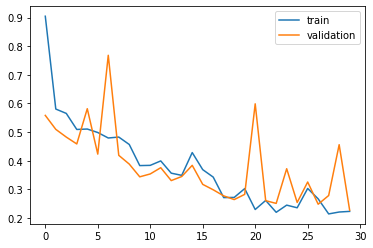

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'],loc='upper right')

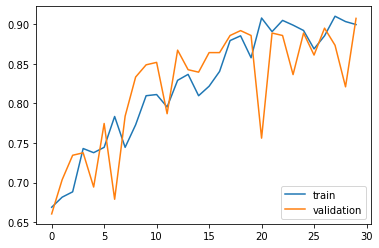

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'],loc='lower right')

In [ ]:
test_acc,loss=model.evaluate(test_imgs)

11/11 [==============================] - 1s 113ms/step - loss: 0.2269 - accuracy: 0.9074


To see how model classifies test dataset

In [ ]:
act_label=test_imgs.classes

In [ ]:
act_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Giving images to model to give predictions on

In [ ]:
prob_pred=model.predict_generator(test_imgs,verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


11/11 [==============================] - 1s 124ms/step


Model 2 returns values:first one is probability of eye being healthy,2nd probability of eye having glaucoma

In [ ]:
prob_pred

array([[1.28703579e-01, 8.71296346e-01],
       [5.57710946e-01, 4.42289054e-01],
       [9.99524593e-01, 4.75389359e-04],
       [9.99044001e-01, 9.56018863e-04],
       [9.99999166e-01, 8.78755372e-07],
       [9.81074870e-01, 1.89250913e-02],
       [5.00904858e-01, 4.99095142e-01],
       [9.99794900e-01, 2.05156495e-04],
       [9.99999642e-01, 3.41146006e-07],
       [9.93857682e-01, 6.14229077e-03],
       [9.99998331e-01, 1.72465298e-06],
       [9.99990463e-01, 9.58361125e-06],
       [1.00000000e+00, 4.82284257e-09],
       [9.84210610e-01, 1.57894064e-02],
       [9.99998450e-01, 1.49372204e-06],
       [1.00000000e+00, 3.08248294e-09],
       [9.98506725e-01, 1.49323966e-03],
       [9.99809563e-01, 1.90461447e-04],
       [1.00000000e+00, 2.90482607e-08],
       [9.85661030e-01, 1.43390186e-02],
       [9.93437350e-01, 6.56257616e-03],
       [9.99981046e-01, 1.89048005e-05],
       [1.00000000e+00, 3.31337482e-08],
       [9.99995947e-01, 4.04042339e-06],
       [9.991385

Taking only the probability of eye being glaucomatous

In [ ]:
prob_lab=prob_pred[:,1]

In [ ]:
prob_lab

array([8.71296346e-01, 4.42289054e-01, 4.75389359e-04, 9.56018863e-04,
       8.78755372e-07, 1.89250913e-02, 4.99095142e-01, 2.05156495e-04,
       3.41146006e-07, 6.14229077e-03, 1.72465298e-06, 9.58361125e-06,
       4.82284257e-09, 1.57894064e-02, 1.49372204e-06, 3.08248294e-09,
       1.49323966e-03, 1.90461447e-04, 2.90482607e-08, 1.43390186e-02,
       6.56257616e-03, 1.89048005e-05, 3.31337482e-08, 4.04042339e-06,
       8.61388457e-04, 5.56852482e-02, 1.25175080e-04, 2.05410109e-03,
       4.09526074e-05, 6.35839160e-06, 1.62618198e-05, 1.98827568e-03,
       2.86782929e-03, 5.05902164e-04, 6.09491207e-02, 1.00447360e-04,
       6.55312976e-03, 3.05582464e-01, 3.14045101e-09, 1.00233336e-03,
       2.89157281e-10, 6.52603269e-01, 2.23862827e-02, 5.68418000e-06,
       2.45738920e-06, 2.36917540e-01, 2.14172597e-03, 6.37731455e-06,
       1.41419325e-04, 6.58142426e-07, 7.25510836e-05, 2.67923716e-02,
       1.69843598e-03, 2.97277253e-02, 1.40127464e-04, 2.12003380e-01,
      

Importing required functions to evaluate model performance from scikitlearn 

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

ROC score evaluates threshold which gives best performance in a binary classification by using ROC curve area

In [ ]:
list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
comp=[]
for val in list:
      predi_lab=prob_lab>val
      score=roc_auc_score(act_label,predi_lab)
      comp.append(score)
comp



[0.8967551059362474,
 0.8975567856461156,
 0.8983584653559838,
 0.8986256919259401,
 0.9085703378507349,
 0.908837564420691,
 0.9031876312273335,
 0.8765604122924222,
 0.8692880320671883]

Above we can see 0.5 is best threshold so we use that to get True/False type output for statement is image glaucomatous or not

In [ ]:
lab_final = prob_lab > 0.6

In [ ]:
lab_final

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

In [ ]:
model.save('MP_FinalModel.h5')

Confusion matrix gives you an idea of number of each of 4 kinds of classification cases that have occured:


1.   Eye is healthy and has been classified as healthy(TN)
2.   Eye is glaucomatous and has been classified as glaucomatous(TP)
3.   Eye is glaucomatous but has been classified as healthy(FN)
4.   Eye is healthy but has been classified as glaucomatous(FP)



In [ ]:
confusion_matrix(act_label,lab_final)

array([[146,   9],
       [ 21, 148]])

Checking ROC score again

In [ ]:
roc_auc_score(act_label,lab_final)

0.9085703378507349

In [14]:
vgg_mod=load_model('/content/drive/MyDrive/MP_FinalModel.h5')

In [15]:
vgg_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 17,223,790
Trainable params: 17,223,790
Non-trainable params: 0
_________________________________________________________________


In [19]:
import numpy as np

In [43]:
veri_img=load_img('/content/drive/MyDrive/n_disc6.jpg',target_size=(224,224,3))


In [44]:
def predict_glaucoma(od_img):
  glauc_array=img_to_array(od_img)
  preprocess_input(glauc_array)
  test_img=np.expand_dims(glauc_array,axis=0)
  test_prob=vgg_mod.predict(test_img,verbose=1)
  prob_glauc=test_prob[:,1]
  prob_norm=test_prob[:,0]
  if prob_glauc>0.6:
    print("Glaucoma detected. "+str(round(prob_glauc[0]*100))+" percent sure")
  else:
    print("No glaucoma detected."+str(round(prob_norm[0]*100))+" percent sure")

In [45]:
predict_glaucoma(veri_img)

1/1 [==============================] - 0s 22ms/step
No glaucoma detected.96 percent sure
